# Evaluation of models on test data

In [7]:
from IPython import get_ipython
ipython = get_ipython()
if ipython:
    ipython.magic("reload_ext autoreload")
    ipython.magic("autoreload 2")
prefix = '1_'
import util
import plotting
from  mitosplit_net import evaluation
import preprocessing

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

from tqdm import tqdm
import tensorflow as tf

/tmp/ipykernel_255116/2731879708.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("reload_ext autoreload")
/tmp/ipykernel_255116/2731879708.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [294]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data and models directories

In [295]:
base_dir = '/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/'
data_path = base_dir+'Data/' 
model_path = base_dir+'Models/' 

## No preprocessing, different batch sizes

### Only mito channel as input

In [296]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [ ]:
from pathlib import Path
folder_name = util.get_filename(model_path, 'ref_f8')
folder_name = [folder for folder in folder_name if folder.split('/')[-1][:3] == 'ref']
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
nb_models = len(folder_name)

model = util.load_model(model_path, [prefix + 'model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b8/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b16/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b32/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b256/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b8/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b16/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b32/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b256/history
Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b8/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b16/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b32/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f8_c9_b256/frames_test
Done

In [298]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

model_pbar = tqdm(model.keys())
for model_name in model_pbar:
  model_pbar.set_description("Processing %s" %model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]

  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del output_data, labels, input_data

Processing ref_f8_c9_b8:   0%|          | 0/4 [00:00<?, ?it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


Processing ref_f8_c9_b16:  25%|██▌       | 1/4 [00:07<00:22,  7.35s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


Processing ref_f8_c9_b32:  50%|█████     | 2/4 [00:16<00:16,  8.13s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


Processing ref_f8_c9_b256:  75%|███████▌  | 3/4 [00:23<00:07,  7.80s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


Processing ref_f8_c9_b256: 100%|██████████| 4/4 [00:30<00:00,  7.65s/it]


#### Threshold optimization

In [ ]:
pred_threshold = np.linspace(0.05, 1, 10, endpoint=True)
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(pred_threshold, model_path, 'ref_pred_threshold')
util.save_pkl(f1_score, model_path, 'ref_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'ref_optimal_pred_threshold')
print("\033[1m\033[31mref written\033[0m")

Processing ref_f8_c9_b8


 90%|█████████ | 9/10 [00:56<00:06,  6.29s/it]/home/stepp/Documents/Software/mitosplit-net/mitosplit_net/evaluation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
100%|██████████| 10/10 [01:02<00:00,  6.22s/it]




Processing ref_f8_c9_b16


100%|██████████| 10/10 [01:00<00:00,  6.03s/it]




Processing ref_f8_c9_b32


100%|██████████| 10/10 [01:01<00:00,  6.16s/it]




Processing ref_f8_c9_b256


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_pred_threshold
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/ref_optimal_pred_threshold
Done.


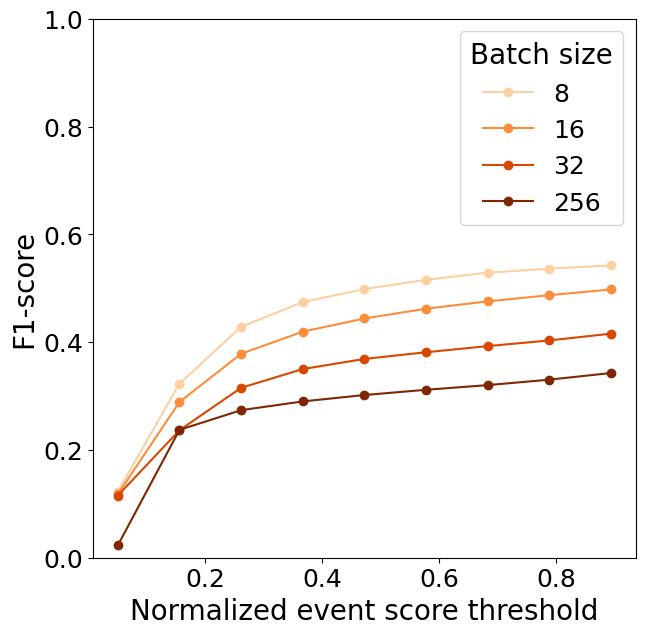

In [300]:
batch_size = [int(model_name.split('_b')[-1]) for model_name in folder_name]

num_models = len(batch_size)
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(7, 7))
for model_name, b, c in zip(model, batch_size, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=b)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Batch size', title_fontsize=20)
plt.show()

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/ref_examples.pdf


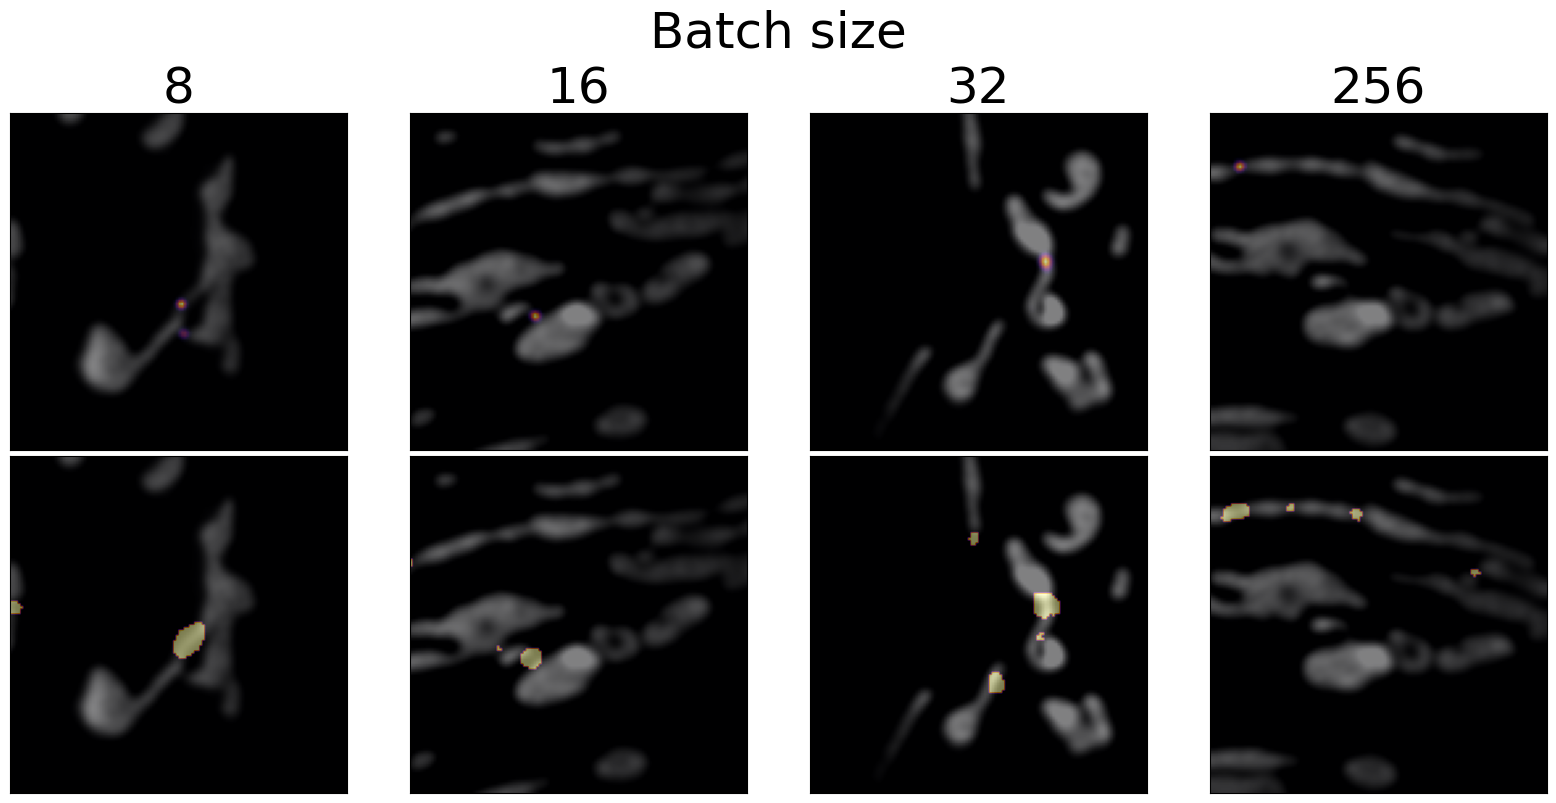

In [301]:
title = 'ref_examples'
filename = base_dir+'Figures/'+title+'.pdf'
print(filename)

title_size = 36

fig, axes = plt.subplots(2, nb_models, figsize=(4*nb_models, 8))
fig.suptitle('Batch size', size=title_size)
for model_name, b, i in zip(folder_name, [8, 16, 32, 256], range(nb_models)):
  frame = np.random.choice(np.where(np.any(np.any(output_test[model_name]>0, axis=-1), axis=-1))[0])
  mask = pred_output_test[model_name][frame]>optimal_pred_threshold[model_name]
  plotting.plot_merge(input_test[model_name][frame], output_test[model_name][frame], title='', ax=axes[0, i])
  plotting.plot_merge(input_test[model_name][frame], pred_output_test[model_name][frame]*mask, title='', ax=axes[1, i])
  axes[0, i].set_title(b, size=title_size)
  
fig.tight_layout(pad=0)
fig.subplots_adjust(wspace=0, hspace=0.02, top=0.85)
#plt.show()
fig.savefig(filename)

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [303]:
fissionStats = {}
for model_name in model:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
  
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T


Model name: ref_f8_c9_b8

Model name: ref_f8_c9_b16

Model name: ref_f8_c9_b32

Model name: ref_f8_c9_b256


/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/ref_fissionStats.png


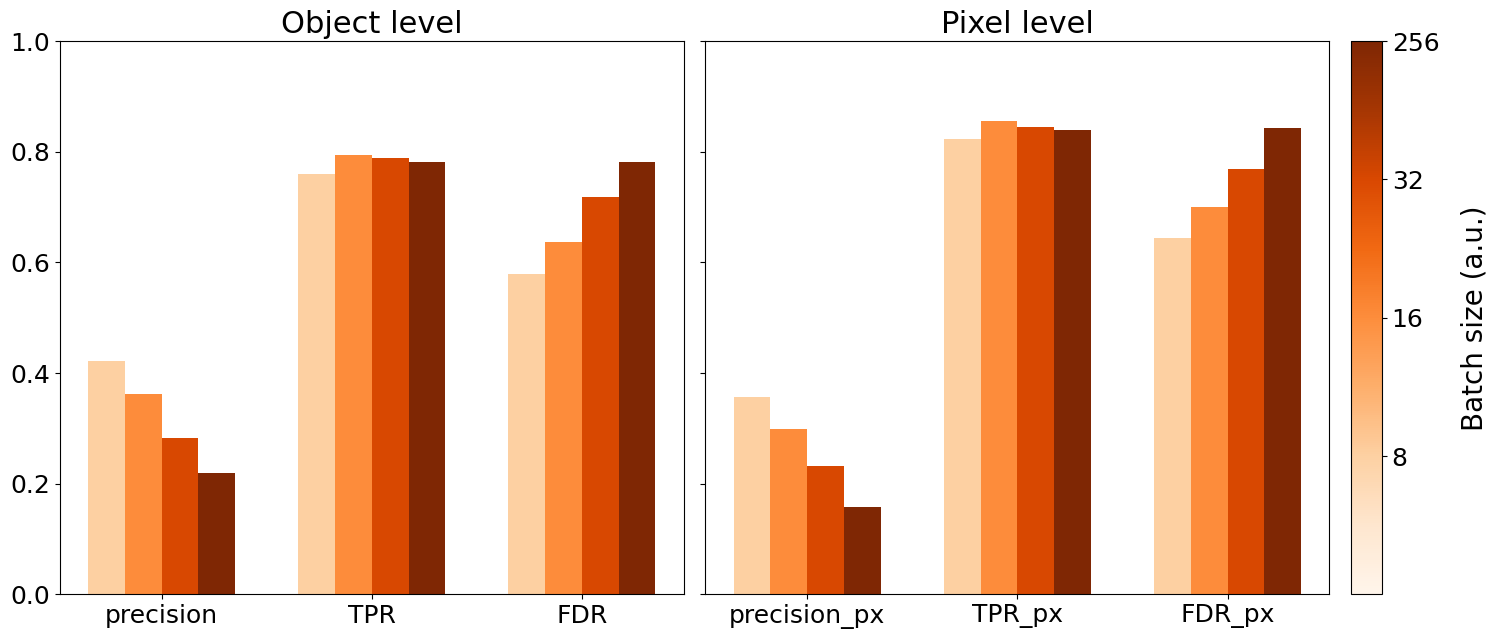

In [304]:
title = 'ref_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])


plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(batch_size)
cbar.set_label('Batch size (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [305]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/ref_det_match_new.png


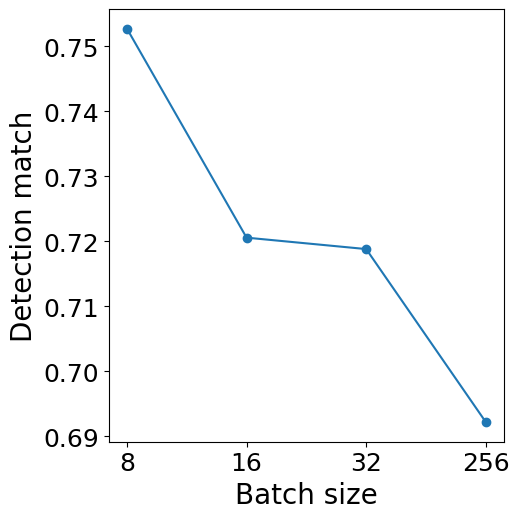

In [306]:
facecolor = (0.13, 0.13, 0.13, 1)
title = 'ref_det_match_new'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(det_match, 'o-')
ax.set_xticks(range(len(det_match)))
ax.set_xticklabels([8, 16, 32, 256])
ax.set_xlabel('Batch size')
ax.set_ylabel('Detection match')

ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.tight_layout(pad=0)
#plt.show()
fig.savefig(filename)

### Mito + Drp1 channels as inputs

In [307]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
input_data = np.stack((input_data, util.load_h5(data_path, 'Drp1')), axis=-1)
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Drp1.h5
Converting to array
Inputs: (37000, 128, 128, 2)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [308]:
folder_name

['ref_f8_c9_b8', 'ref_f8_c9_b16', 'ref_f8_c9_b32', 'ref_f8_c9_b256']

In [ ]:
folder_name = util.get_filename(model_path, 'multich_ref_f8')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])

folder_name = [folder_name[i] for i in idx_sort]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
# folder_name = [folder for folder in folder_name if folder.split('/')[-1][:3] == 'mul']
nb_models = len(folder_name)

model = util.load_model(model_path, [prefix + 'model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b256/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b256/history
Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b8/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b16/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f8_c9_b32/frames_test

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_f

In [310]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

model_pbar = tqdm(model.keys())
for model_name in model_pbar:
  model_pbar.set_description("Processing %s" %model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]

  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del output_data, labels, input_data

Processing multich_ref_f8_c9_b8:   0%|          | 0/4 [00:00<?, ?it/s]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


Processing multich_ref_f8_c9_b16:  25%|██▌       | 1/4 [00:07<00:23,  7.76s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


Processing multich_ref_f8_c9_b32:  50%|█████     | 2/4 [00:15<00:15,  7.63s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


Processing multich_ref_f8_c9_b256:  75%|███████▌  | 3/4 [00:23<00:07,  7.76s/it]

232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


Processing multich_ref_f8_c9_b256: 100%|██████████| 4/4 [00:31<00:00,  7.79s/it]


#### Threshold optimization

In [311]:
pred_threshold = np.linspace(0.05, 1, 10, endpoint=True)
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'multich_ref_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'multich_ref_optimal_pred_threshold')

Processing multich_ref_f8_c9_b8


 90%|█████████ | 9/10 [00:56<00:06,  6.43s/it]/home/stepp/Documents/Software/mitosplit-net/mitosplit_net/evaluation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
100%|██████████| 10/10 [01:02<00:00,  6.29s/it]




Processing multich_ref_f8_c9_b16


100%|██████████| 10/10 [01:01<00:00,  6.11s/it]




Processing multich_ref_f8_c9_b32


100%|██████████| 10/10 [01:00<00:00,  6.08s/it]




Processing multich_ref_f8_c9_b256


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_ref_optimal_pred_threshold
Done.


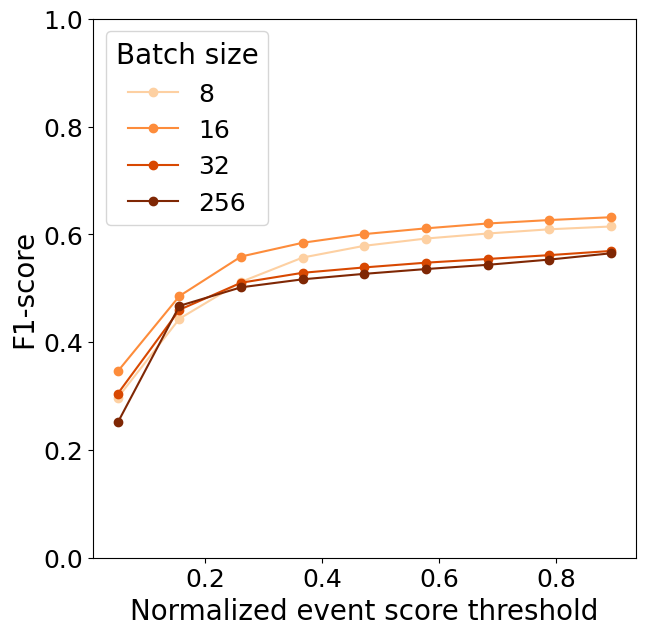

In [312]:
batch_size = [int(model_name.split('_b')[-1]) for model_name in folder_name]

num_models = len(batch_size)
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(7, 7))
for model_name, b, c in zip(model, batch_size, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=b)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Batch size', title_fontsize=20)
plt.show()

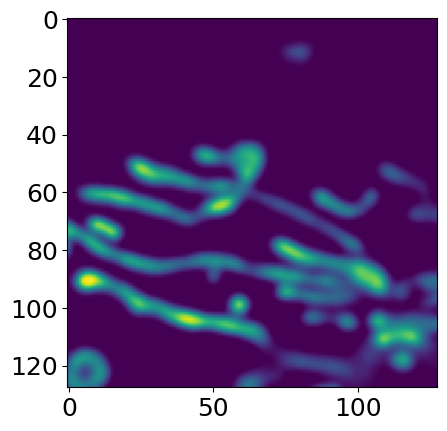

In [313]:
plt.imshow(input_test[model_name][frame][:, :, 0])

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_ref_examples.pdf


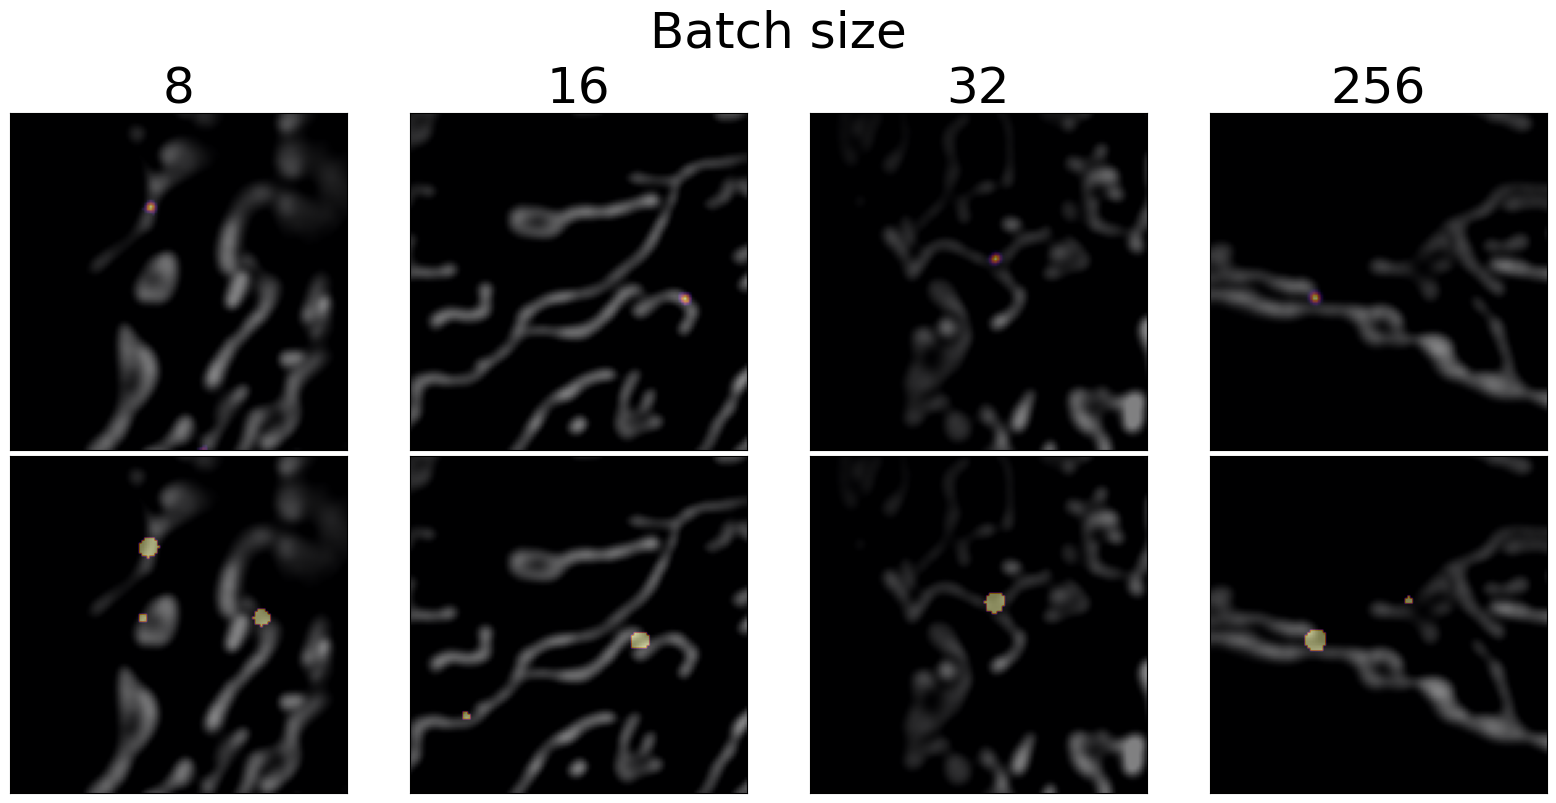

In [314]:
title = 'multich_ref_examples'
filename = base_dir+'Figures/'+title+'.pdf'
print(filename)

title_size = 36

fig, axes = plt.subplots(2, nb_models, figsize=(4*nb_models, 8))
fig.suptitle('Batch size', size=title_size)
for model_name, b, i in zip(folder_name, [8, 16, 32, 256], range(nb_models)):
  frame = np.random.choice(np.where(np.any(np.any(output_test[model_name]>0, axis=-1), axis=-1))[0])
  mask = pred_output_test[model_name][frame]>optimal_pred_threshold[model_name]
  plotting.plot_merge(input_test[model_name][frame][:, :, 0], output_test[model_name][frame], title='', ax=axes[0, i])
  plotting.plot_merge(input_test[model_name][frame][:, :, 0], pred_output_test[model_name][frame]*mask, title='', ax=axes[1, i])
  axes[0, i].set_title(b, size=title_size)
  
fig.tight_layout(pad=0)
fig.subplots_adjust(wspace=0, hspace=0.02, top=0.85)
#plt.show()
fig.savefig(filename)

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name][:, :, :, 0], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [316]:
fissionStats = {}
for model_name in model:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])
  
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T


Model name: multich_ref_f8_c9_b8

Model name: multich_ref_f8_c9_b16

Model name: multich_ref_f8_c9_b32

Model name: multich_ref_f8_c9_b256


/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_ref_fissionStats.png


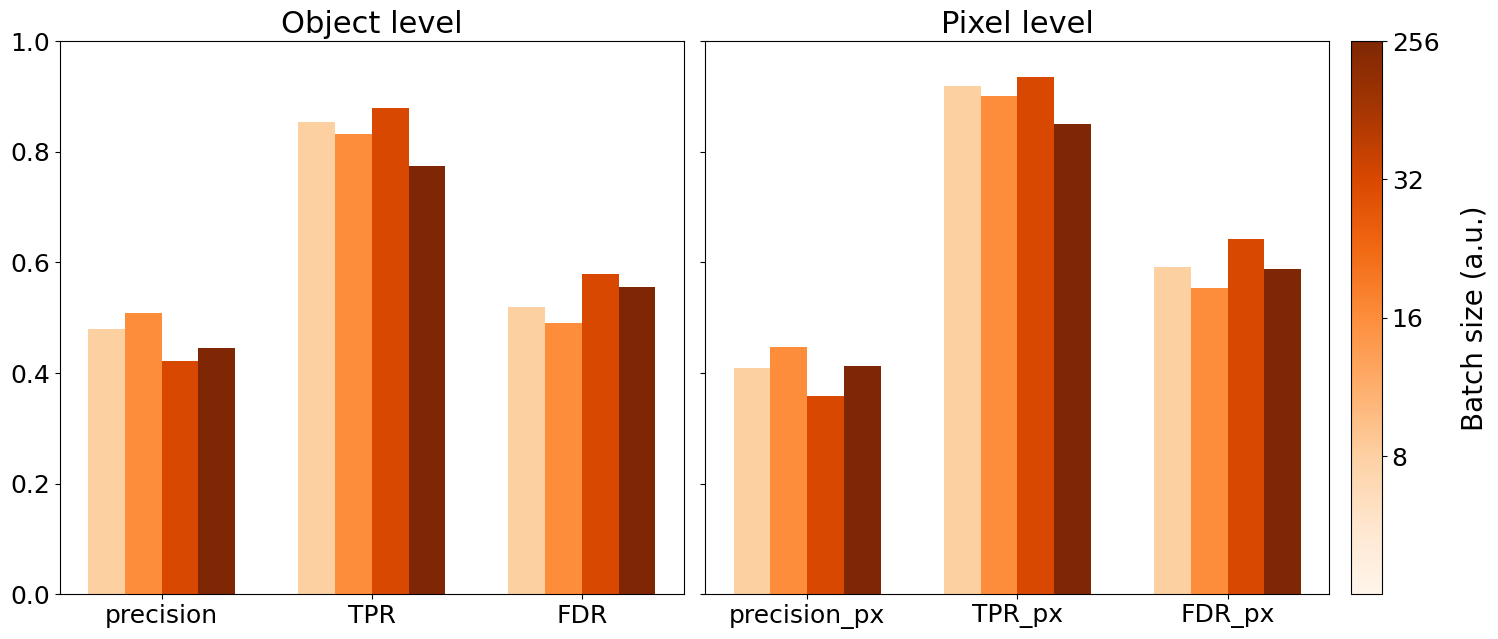

In [317]:
title = 'multich_ref_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])


plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(batch_size)
cbar.set_label('Batch size (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [318]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_ref_det_match.png


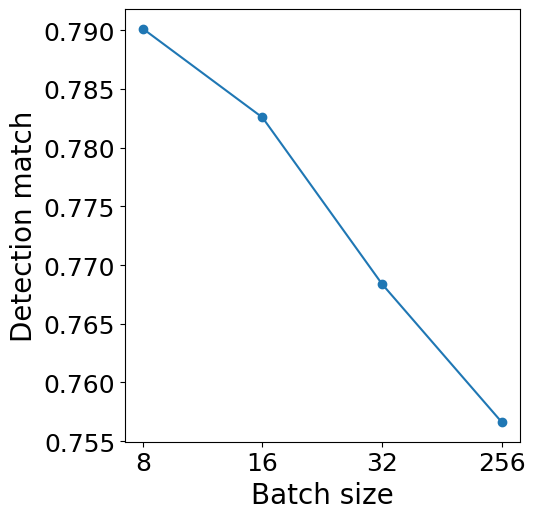

In [319]:
facecolor = (0.13, 0.13, 0.13, 1)
title = 'multich_ref_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(det_match, 'o-')
ax.set_xticks(range(len(det_match)))
ax.set_xticklabels([8, 16, 32, 256])
ax.set_xlabel('Batch size')
ax.set_ylabel('Detection match')

ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.tight_layout(pad=0)
#plt.show()
fig.savefig(filename)

## Mito & WatProc, different spot sizes

### Only mito channel as input

In [320]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [321]:
#Outputs
folder_name = util.get_filename(model_path, 'wp_f8')
folder_name = [model_name for model_name in folder_name if np.all([tag not in model_name for tag in ['aug', 'temp', 'multich']])]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
num_models = len(folder_name)

model = util.load_model(model_path, [prefix + 'model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t68/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t1/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t98/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t33/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t48/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t6/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.0_t21/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t68/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t1/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.2_t98/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t33/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.1_t48/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s1.9_t6/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f8_c9_b16_s2.0_t21/history
Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit

In [322]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name, s, t in zip(folder_name, dilation_sigma, dilation_threshold):
  print('\nModel: %s'%model_name)
  
  #Inputs
  input_test[model_name] = input_data[frames_test[model_name]]
  
  metadata = 's%.1f_t%.i'%(s, t)
  #Outputs
  output_data = util.load_h5(data_path, 'WatProc_'+metadata)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data
  
  #Labels
  labels = util.load_h5(data_path, 'proc_labels_'+metadata)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del input_data


Model: wp_f8_c9_b16_s2.2_t68

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t1.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Model: wp_f8_c9_b16_s1.9_t1

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t6.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t6.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Model: wp_f8_c9_b16_s2.2_t98

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s2.0_t21.h5
Converting to array
Outputs: (37000, 128, 128)

Load

#### Threshold optimization

In [323]:
pred_threshold = np.linspace(0.05, 1, 10, endpoint=True)
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(pred_threshold, model_path, 'pred_threshold')
util.save_pkl(f1_score, model_path, 'wp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'wp_optimal_pred_threshold')
print("\033[1m\033[31mwp written\033[0m")

Processing wp_f8_c9_b16_s2.2_t68


 80%|████████  | 8/10 [00:43<00:10,  5.34s/it]/home/stepp/Documents/Software/mitosplit-net/mitosplit_net/evaluation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
100%|██████████| 10/10 [00:53<00:00,  5.37s/it]




Processing wp_f8_c9_b16_s1.9_t1


100%|██████████| 10/10 [00:51<00:00,  5.20s/it]




Processing wp_f8_c9_b16_s2.2_t98


100%|██████████| 10/10 [00:48<00:00,  4.80s/it]




Processing wp_f8_c9_b16_s2.1_t33


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]




Processing wp_f8_c9_b16_s2.1_t48


100%|██████████| 10/10 [00:42<00:00,  4.25s/it]




Processing wp_f8_c9_b16_s1.9_t6


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]




Processing wp_f8_c9_b16_s2.0_t21


100%|██████████| 10/10 [00:36<00:00,  3.69s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/pred_threshold
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/wp_optimal_pred_threshold
Done.


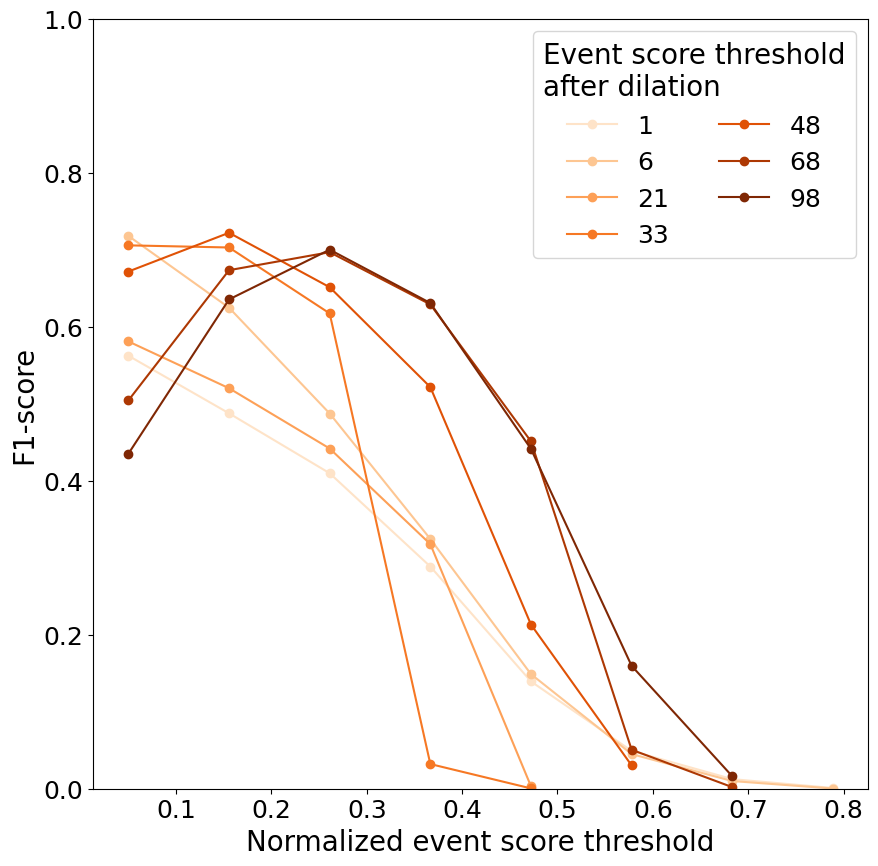

In [324]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [326]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: wp_f8_c9_b16_s2.2_t68

Model name: wp_f8_c9_b16_s1.9_t1

Model name: wp_f8_c9_b16_s2.2_t98

Model name: wp_f8_c9_b16_s2.1_t33

Model name: wp_f8_c9_b16_s2.1_t48

Model name: wp_f8_c9_b16_s1.9_t6

Model name: wp_f8_c9_b16_s2.0_t21


In [327]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/wp_fissionStats.png


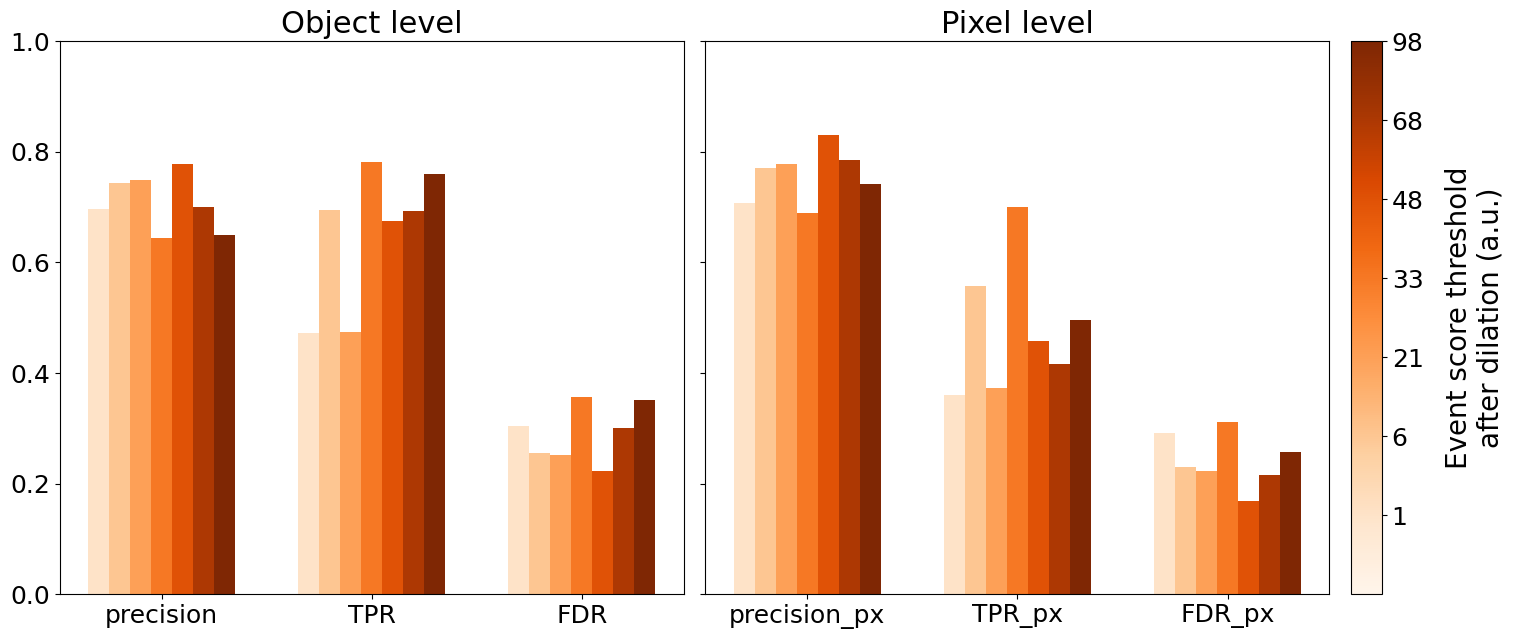

In [328]:
title = 'wp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(dilation_threshold)
cbar.set_label('Event score threshold\nafter dilation (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [329]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/wp_det_match.png


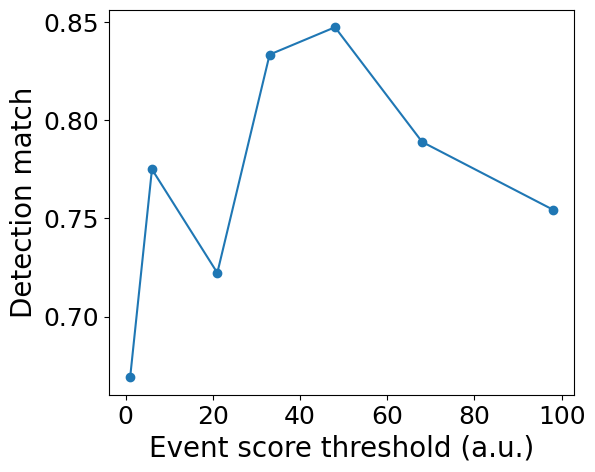

In [330]:
title = 'wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

### Mito + Drp1 channels as inputs

In [331]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
input_data = np.stack((input_data, util.load_h5(data_path, 'Drp1')), axis=-1)
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Drp1.h5
Converting to array
Inputs: (37000, 128, 128, 2)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [ ]:
#Outputs
folder_name = util.get_filename(model_path, 'multich_wp_f8')
folder_name = [model_name for model_name in folder_name if np.all([tag not in model_name for tag in ['aug', 'temp']])]
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
num_models = len(folder_name)

model = util.load_model(model_path, [prefix + 'model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)

In [333]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name, s, t in zip(folder_name, dilation_sigma, dilation_threshold):
  print('\nModel: %s'%model_name)
  
  #Inputs
  input_test[model_name] = input_data[frames_test[model_name]]
  
  metadata = 's%.1f_t%.i'%(s, t)
  #Outputs
  output_data = util.load_h5(data_path, 'WatProc_'+metadata)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data
  
  #Labels
  labels = util.load_h5(data_path, 'proc_labels_'+metadata)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del input_data


Model: multich_wp_f8_c9_b16_s2.2_t68

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t1.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t1.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Model: multich_wp_f8_c9_b16_s2.2_t98

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s1.9_t6.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/proc_labels_s1.9_t6.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Model: multich_wp_f8_c9_b16_s2.1_t48

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/WatProc_s2.0_t21.h5
Converting to array
Outputs

#### Threshold optimization

In [334]:
pred_threshold = np.linspace(0.05, 1, 10, endpoint=True)
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'multich_wp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'multich_wp_optimal_pred_threshold')

Processing multich_wp_f8_c9_b16_s2.2_t68


 70%|███████   | 7/10 [00:37<00:16,  5.38s/it]/home/stepp/Documents/Software/mitosplit-net/mitosplit_net/evaluation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
100%|██████████| 10/10 [00:53<00:00,  5.39s/it]




Processing multich_wp_f8_c9_b16_s2.2_t98


100%|██████████| 10/10 [00:50<00:00,  5.07s/it]




Processing multich_wp_f8_c9_b16_s2.1_t48


100%|██████████| 10/10 [00:48<00:00,  4.87s/it]




Processing multich_wp_f8_c9_b16_s2.0_t21


100%|██████████| 10/10 [00:46<00:00,  4.60s/it]




Processing multich_wp_f8_c9_b16_s1.9_t6


100%|██████████| 10/10 [00:43<00:00,  4.31s/it]




Processing multich_wp_f8_c9_b16_s2.1_t33


100%|██████████| 10/10 [00:41<00:00,  4.10s/it]




Processing multich_wp_f8_c9_b16_s1.9_t1


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_wp_optimal_pred_threshold
Done.


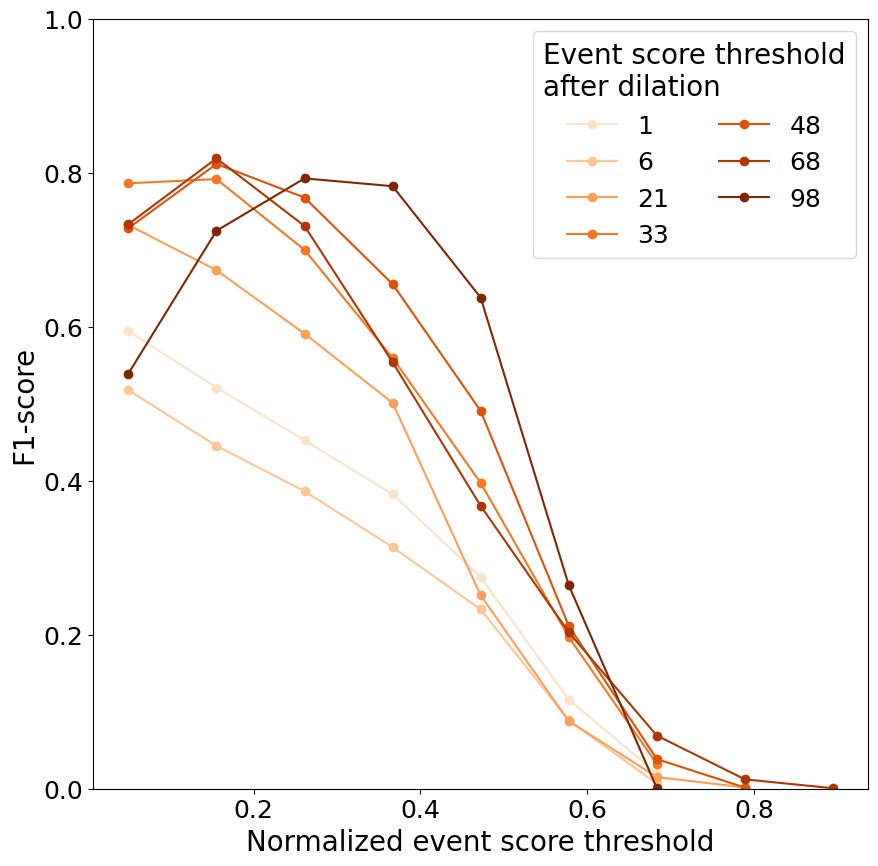

In [335]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name][:, :, :, 0], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [337]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: multich_wp_f8_c9_b16_s2.2_t68

Model name: multich_wp_f8_c9_b16_s2.2_t98

Model name: multich_wp_f8_c9_b16_s2.1_t48

Model name: multich_wp_f8_c9_b16_s2.0_t21

Model name: multich_wp_f8_c9_b16_s1.9_t6

Model name: multich_wp_f8_c9_b16_s2.1_t33

Model name: multich_wp_f8_c9_b16_s1.9_t1


In [338]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_wp_fissionStats.png


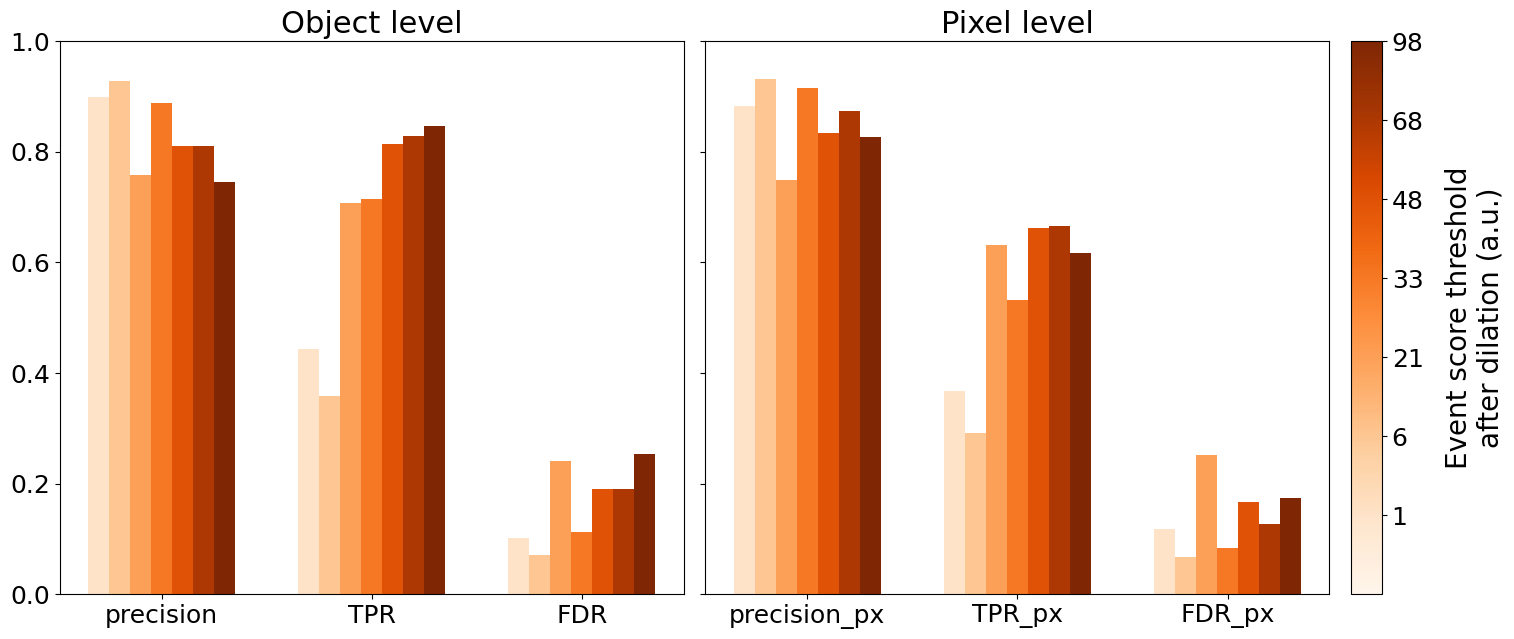

In [339]:
title = 'multich_wp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(dilation_threshold)
cbar.set_label('Event score threshold\nafter dilation (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [340]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_wp_det_match.png


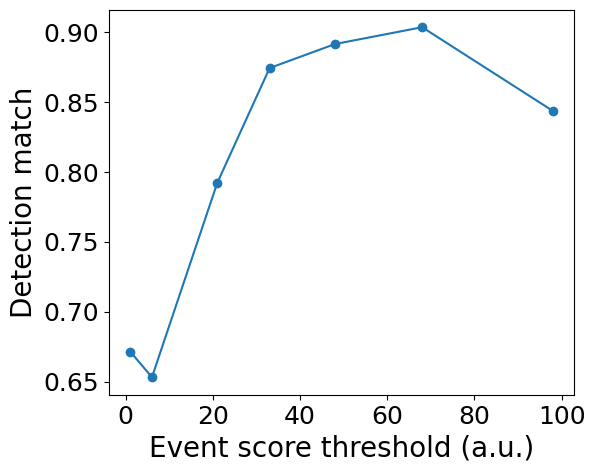

In [341]:
title = 'multich_wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

## Spatiotemporal filtered Mito & WatProc

### Only mito channel as input

In [ ]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]

In [ ]:
#Outputs
folder_name = util.get_filename(model_path, 'spatemp_wp')
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
folder_name = [folder for folder in folder_name if 'multich' not in folder]
folder_name = [folder for folder in folder_name if 'optimal' not in folder]
folder_name = [folder for folder in folder_name if 'f1_score' not in folder]
num_models = len(folder_name)

model = util.load_model(model_path, [prefix + 'model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f8_c9_b16_s2.1

In [344]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name in folder_name:
  print('\nModel: %s'%model_name)
  metadata = model_name.split('b16_')[-1]
  output_data_name = 'spatemp_WatProc_'+metadata
  labels_name = 'spatemp_proc_labels_'+metadata
  
  #Outputs
  output_data = util.load_h5(data_path, output_data_name)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  labels = util.load_h5(data_path, labels_name)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  
del input_data


Model: spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s2.2_t68_w5_gt109.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s2.2_t68_w5_gt109.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Model: spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s2.1_t33_w5_gt72.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s2.1_t33_w5_gt72.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step

Model: spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127

Loading /mnt/LEB/Scientific_projects/deep_event

#### Threshold optimization

In [345]:
pred_threshold = util.load_pkl(model_path, 'pred_threshold')
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'spatemp_wp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'spatemp_wp_optimal_pred_threshold')
print("\033[1m\033[31mspatemp written\033[0m")


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/pred_threshold
Processing spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109


 60%|██████    | 6/10 [00:21<00:14,  3.59s/it]/home/stepp/Documents/Software/mitosplit-net/mitosplit_net/evaluation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
100%|██████████| 10/10 [00:35<00:00,  3.60s/it]




Processing spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]




Processing spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127


100%|██████████| 10/10 [00:34<00:00,  3.41s/it]




Processing spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55


100%|██████████| 10/10 [00:41<00:00,  4.18s/it]




Processing spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49


100%|██████████| 10/10 [00:41<00:00,  4.18s/it]




Processing spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]




Processing spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/spatemp_wp_optimal_pred_threshold
Done.


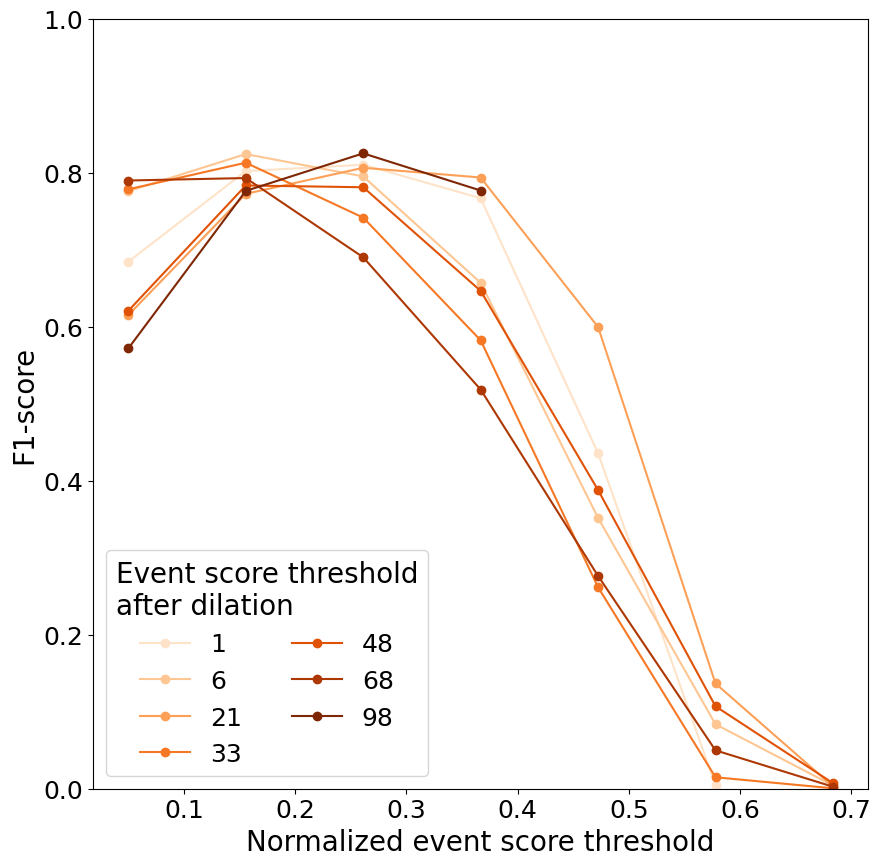

In [346]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [348]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109

Model name: spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Model name: spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127

Model name: spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55

Model name: spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49

Model name: spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38

Model name: spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91


In [349]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/spatemp_wp_fissionStats.png


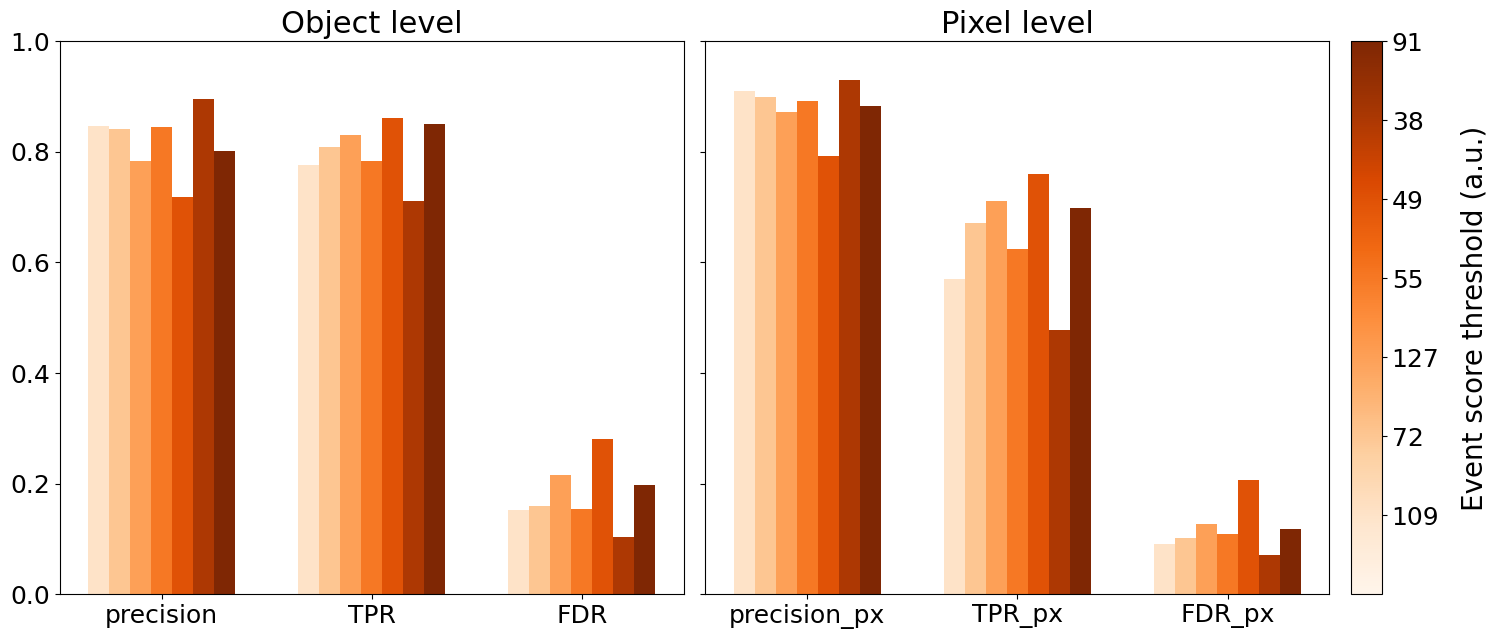

In [350]:
gaussian_threshold = np.array([int(model_name.split('_gt')[-1]) for model_name in model])
title = 'spatemp_wp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(gaussian_threshold)
cbar.set_label('Event score threshold (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [351]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/spatemp_wp_det_match.png


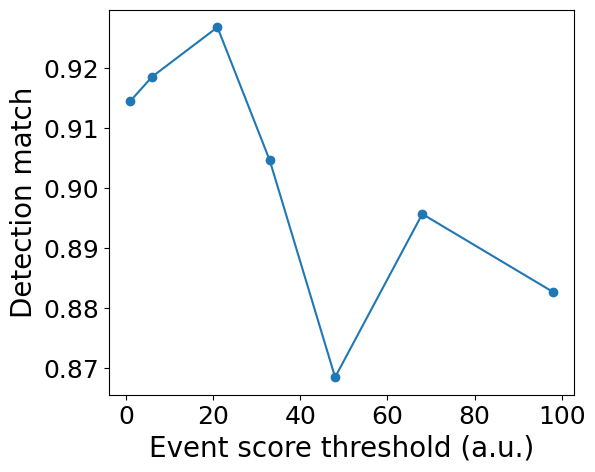

In [352]:
title = 'spatemp_wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

### Mito + Drp1 channels as inputs

In [353]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
input_data = np.stack((input_data, util.load_h5(data_path, 'Drp1')), axis=-1)
print('Inputs'+':', input_data.shape)

dilation_sigma = util.load_pkl(data_path, 'max_optimal_sigma')
dilation_threshold = util.load_pkl(data_path, 'max_intensity_threshold')
num_sigmas = dilation_sigma.shape[0]


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Mito.h5
Converting to array

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/Drp1.h5
Converting to array
Inputs: (37000, 128, 128, 2)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_optimal_sigma

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/max_intensity_threshold


In [354]:
#Outputs
folder_name = util.get_filename(model_path, 'multich_spatemp_wp_f8')
folder_name = [str(Path(folder).parts[-1]) for folder in folder_name]
num_models = len(folder_name)

model = util.load_model(model_path, [prefix + 'model']*num_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*num_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*num_models, folder_name, as_type=dict)


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127/model.h5



Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109/model.h5


Done.

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127/history

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo

In [355]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test = {}

for model_name in folder_name:
  print('\nModel: %s'%model_name)
  metadata = model_name.split('b16_')[-1]
  output_data_name = 'spatemp_WatProc_'+metadata
  labels_name = 'spatemp_proc_labels_'+metadata
  
  #Outputs
  output_data = util.load_h5(data_path, output_data_name)
  print('Outputs:', output_data.shape)
  output_test[model_name] = output_data[frames_test[model_name]]
  del output_data

  labels = util.load_h5(data_path, labels_name)
  print('Labels:', labels.shape)
  labels_test[model_name] = labels[frames_test[model_name]]
  del labels
  
  input_test[model_name] = input_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  
del input_data


Model: multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s2.1_t33_w5_gt72.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s2.1_t33_w5_gt72.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Model: multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_WatProc_s1.9_t6_w5_gt49.h5
Converting to array
Outputs: (37000, 128, 128)

Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Data/spatemp_proc_labels_s1.9_t6_w5_gt49.h5
Converting to array
Labels: (37000, 128, 128)
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Model: multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55

Loading /mnt/LEB/Scientific_pr

#### Threshold optimization

In [356]:
pred_threshold = util.load_pkl(model_path, 'pred_threshold')
f1_score = {}
optimal_pred_threshold = {}
pred_labels_test = {}

for model_name in model:
  print("Processing %s" %model_name)
  f1_score[model_name] = evaluation.get_f1_curve(labels_test[model_name], pred_output_test[model_name], pred_threshold)
  optimal_pred_threshold[model_name] = evaluation.get_optimal_threshold(pred_threshold, f1_score[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name], threshold=optimal_pred_threshold[model_name])
  print('\n')
  
util.save_pkl(f1_score, model_path, 'multich_spatemp_f1_score')
util.save_pkl(optimal_pred_threshold, model_path, 'multich_spatemp_optimal_pred_threshold')


Loading /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/pred_threshold
Processing multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72


 50%|█████     | 5/10 [00:19<00:19,  3.94s/it]/home/stepp/Documents/Software/mitosplit-net/mitosplit_net/evaluation.py:83: RuntimeWarning: invalid value encountered in scalar divide
  return tp/(tp+fp)
100%|██████████| 10/10 [00:39<00:00,  3.96s/it]




Processing multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55


100%|██████████| 10/10 [00:43<00:00,  4.32s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91


100%|██████████| 10/10 [00:39<00:00,  3.91s/it]




Processing multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]




Processing multich_spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]





Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_f1_score
Done.

Saving /mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Models/multich_spatemp_optimal_pred_threshold
Done.


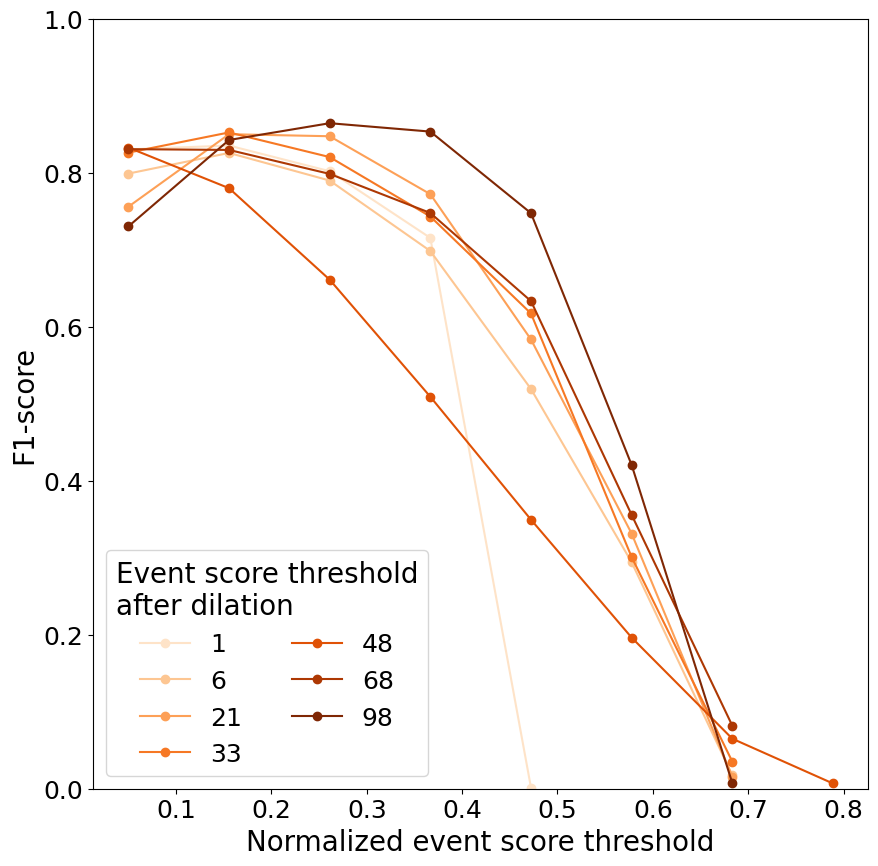

In [357]:
cbar_ticks = np.arange(num_models)

norm_bounds = -1, num_models-1
norm = Normalize(*norm_bounds)
cmap = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
colors = cmap.get_cmap()(norm(cbar_ticks))

fig, ax = plt.subplots(figsize=(10, 10))
for model_name, thr, c in zip(model, dilation_threshold, colors):
  ax.plot(pred_threshold, f1_score[model_name], 'o-', color=c, label=thr)

ax.set(xlabel='Normalized event score threshold', ylabel='F1-score', ylim=(0, 1))
ax.legend(title='Event score threshold\nafter dilation', title_fontsize=20, ncol=2)
plt.show()

In [ ]:
for model_name in folder_name:
  mask = pred_output_test[model_name]>optimal_pred_threshold[model_name]
  plotting.plot_outputs(input_test[model_name][:, :, :, 0], output_test[model_name], 
                        pred_output_test[model_name]*mask, frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

#### Labels binary overlap

In [359]:
fissionStats = {}
for model_name in labels_test:
  print('\nModel name:', model_name)
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])


Model name: multich_spatemp_wp_f8_c9_b16_s2.1_t33_w5_gt72

Model name: multich_spatemp_wp_f8_c9_b16_s1.9_t6_w5_gt49

Model name: multich_spatemp_wp_f8_c9_b16_s2.0_t21_w5_gt55

Model name: multich_spatemp_wp_f8_c9_b16_s2.1_t48_w5_gt91

Model name: multich_spatemp_wp_f8_c9_b16_s1.9_t1_w5_gt38

Model name: multich_spatemp_wp_f8_c9_b16_s2.2_t98_w5_gt127

Model name: multich_spatemp_wp_f8_c9_b16_s2.2_t68_w5_gt109


In [360]:
fissionStats = pd.DataFrame(fissionStats, index=['TP', 'FP', 'FN', 'TP_px', 'FP_px', 'FN_px']).T
fissionStats['precision'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FP'])
fissionStats['TPR'] = fissionStats['TP']/(fissionStats['TP']+fissionStats['FN'])
fissionStats['FDR'] = fissionStats['FP']/(fissionStats['TP']+fissionStats['FP'])

fissionStats['precision_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])
fissionStats['TPR_px'] = fissionStats['TP_px']/(fissionStats['TP_px']+fissionStats['FN_px'])
fissionStats['FDR_px'] = fissionStats['FP_px']/(fissionStats['TP_px']+fissionStats['FP_px'])

fissionStats = fissionStats.T

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_spatemp_fissionStats.png


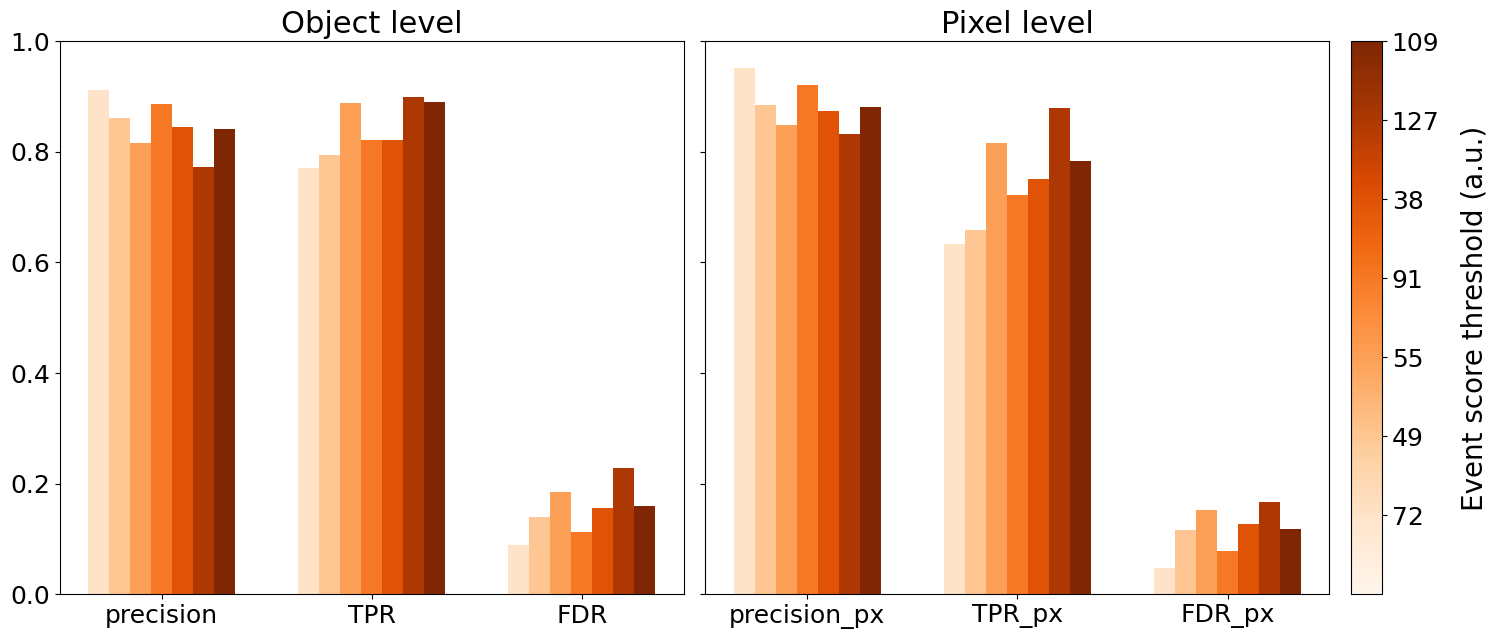

In [361]:
gaussian_threshold = np.array([int(model_name.split('_gt')[-1]) for model_name in model])
title = 'multich_spatemp_fissionStats'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig = plt.figure(figsize=(7*2, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

axes = []
axes += [fig.add_subplot(gs[0])]
axes += [fig.add_subplot(gs[1])]
cax = fig.add_subplot(gs[2])

plotting.plot_metrics_comparison(fissionStats.loc[['precision', 'TPR', 'FDR']], xscale=2, color=colors, ax=axes[0], ylim=[0, 1], legend=False)  
plotting.plot_metrics_comparison(fissionStats.loc[['precision_px', 'TPR_px', 'FDR_px']], xscale=2, color=colors, ax=axes[1], ylim=[0, 1], legend=False)
axes[1].set_yticklabels([])

for ax, title in zip(axes, ['Object level', 'Pixel level']):
  ax.set_title(title, size=22)
  ax.tick_params(axis='x')
  ax.tick_params(axis='y')

cbar = fig.colorbar(cmap, cax=cax, ticks=cbar_ticks)
cbar.set_ticklabels(gaussian_threshold)
cbar.set_label('Event score threshold (a.u.)', labelpad=15)


plt.tight_layout(pad=0)
fig.subplots_adjust(wspace=0.05, top=0.84, right=0.98)

#plt.show()
fig.savefig(filename)

#### Detection match

In [362]:
det_match = [evaluation.detection_match(output_test[model_name], pred_output_test[model_name]) for model_name in folder_name]

/mnt/LEB/Scientific_projects/deep_events_WS/data/single_channel_fluo/MitoSplit-Net/Figures/multich_spatemp_wp_det_match.png


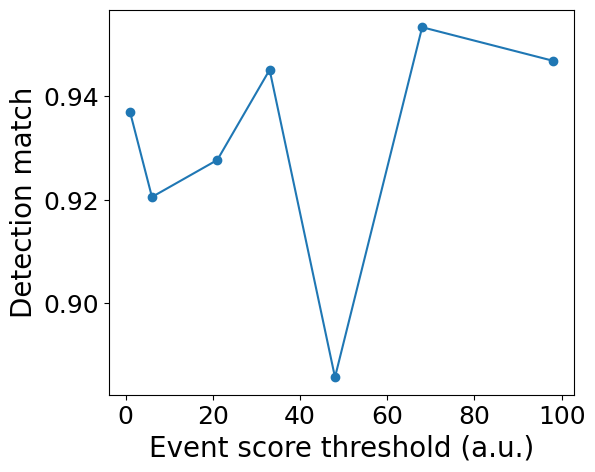

: 

In [363]:
title = 'multich_spatemp_wp_det_match'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(dilation_threshold, det_match, 'o-')
ax.set(xlabel='Event score threshold (a.u.)', ylabel='Detection match')
#plt.show()
fig.savefig(filename)

In [ ]:
print("\033[1m\033[31mDONE DONE DONE DONE\033[0m")